# Predicción de fraudes de seguros

El conjunto de datos, denominado "insurance_claims.csv", es una colección completa de registros de siniestros de seguros. Cada fila representa un siniestro individual, y las columnas representan diversas características asociadas a ese siniestro. 

En el conjunto de datos destacan características como 'months_as_customer', 'age', policy_number, ...etc. El interés principal se centra en la variable "fraud_reported", que indica la legitimidad del siniestro.

In [34]:
# importando librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# cargando el dataset
df = pd.read_csv('insurance_claims.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [3]:
# informacion del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

# Procesamiento del dataframe

In [4]:
# extrayendo el año de la columna policy_bind_date
df['policy_bind_date'] = df['policy_bind_date'].str[:4].astype(int)

In [5]:
# eliminando columnas innecesarias
df.drop(columns=['incident_date', 'incident_location'], inplace=True)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [6]:
# visualizando la cantidad de clases por columnas
df[df.select_dtypes(include=['object']).columns].nunique()

policy_state                3
policy_csl                  3
insured_sex                 2
insured_education_level     7
insured_occupation         14
insured_hobbies            20
insured_relationship        6
incident_type               4
collision_type              4
incident_severity           4
authorities_contacted       4
incident_state              7
incident_city               7
property_damage             3
police_report_available     3
auto_make                  14
auto_model                 39
fraud_reported              2
dtype: int64

Debido a la alta cantidad de modelos de vehiculos, trataremos de agruparlos en varias clases.

In [7]:
# visualizando las clases de la columna auto_model
df['auto_model'].unique()

array(['92x', 'E400', 'RAM', 'Tahoe', 'RSX', '95', 'Pathfinder', 'A5',
       'Camry', 'F150', 'A3', 'Highlander', 'Neon', 'MDX', 'Maxima',
       'Legacy', 'TL', 'Impreza', 'Forrestor', 'Escape', 'Corolla',
       '3 Series', 'C300', 'Wrangler', 'M5', 'X5', 'Civic', 'Passat',
       'Silverado', 'CRV', '93', 'Accord', 'X6', 'Malibu', 'Fusion',
       'Jetta', 'ML350', 'Ultima', 'Grand Cherokee'], dtype=object)

In [8]:
# definiendo una funcion para agrupar las clases
def cluster_auto_model(model):
    if model in ['92x', 'E400', 'A5', '3 Series', 'C300', 'M5', 'X5', 'X6', 'Fusion', 'Jetta', 'ML350']:
        return 'Luxury/Sports'
    elif model in ['RAM', 'Tahoe', 'Highlander', 'Escape', 'Silverado', 'Wrangler', 'Malibu', 'Ultima', 'Grand Cherokee']:
        return 'SUV/Truck'
    elif model in ['95', 'Neon', 'Legacy', 'Impreza', 'Forrestor']:
        return 'Sedan/Wagon'
    elif model in ['Pathfinder', 'MDX', 'Maxima', 'TL', 'CRV', 'Accord', 'Passat']:
        return 'Midsize SUV/Sedan'
    elif model in ['Camry', 'F150', 'A3', 'Corolla', 'Civic']:
        return 'Compact Car/Truck'
    else:
        return 'Other'

# aplicando la funcion a la columna auto_model
df['auto_model'] = df['auto_model'].apply(cluster_auto_model)

In [9]:
# reemplazando el valor ? por unknown en el dataframe
df.replace('?', 'unknown', inplace=True)
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,Luxury/Sports,2004,Y
1,228,42,342868,2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,unknown,Minor Damage,Police,VA,Riverwood,8,1,unknown,0,0,unknown,5070,780,780,3510,Mercedes,Luxury/Sports,2007,Y
2,134,29,687698,2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,SUV/Truck,2007,N
3,256,41,227811,1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,unknown,1,2,NO,63400,6340,6340,50720,Chevrolet,SUV/Truck,2014,Y
4,228,44,367455,2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,unknown,Minor Damage,NaN,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,Other,2009,N


In [10]:
# chequeando valores faltantes
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

authorities_contacted    9.1
dtype: float64

In [11]:
# rellenando valores faltantes de la columna authorities_contacted con la moda
df['authorities_contacted'] = df['authorities_contacted'].fillna(df['authorities_contacted'].mode()[0])

In [12]:
# estadistica de las variables categoricas
df.describe(include='O').T

,count,unique,top,freq
policy_state,1000,3,OH,352
policy_csl,1000,3,250/500,351
insured_sex,1000,2,FEMALE,537
insured_education_level,1000,7,JD,161
insured_occupation,1000,14,machine-op-inspct,93
insured_hobbies,1000,20,reading,64
insured_relationship,1000,6,own-child,183
incident_type,1000,4,Multi-vehicle Collision,419
collision_type,1000,4,Rear Collision,292
incident_severity,1000,4,Minor Damage,354


In [13]:
# estadistica de las variables numericas
round(df.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,204.0,115.1,0.0,115.8,199.5,276.2,479.0
age,1000.0,38.9,9.1,19.0,32.0,38.0,44.0,64.0
policy_number,1000.0,546238.6,257063.0,100804.0,335980.2,533135.0,759099.8,999435.0
policy_bind_date,1000.0,2001.6,7.4,1990.0,1995.0,2002.0,2008.0,2015.0
policy_deductable,1000.0,1136.0,611.9,500.0,500.0,1000.0,2000.0,2000.0
policy_annual_premium,1000.0,1256.4,244.2,433.3,1089.6,1257.2,1415.7,2047.6
umbrella_limit,1000.0,1101000.0,2297406.6,-1000000.0,0.0,0.0,0.0,10000000.0
insured_zip,1000.0,501214.5,71701.6,430104.0,448404.5,466445.5,603251.0,620962.0
capital-gains,1000.0,25126.1,27872.2,0.0,0.0,0.0,51025.0,100500.0
capital-loss,1000.0,-26793.7,28104.1,-111100.0,-51500.0,-23250.0,0.0,0.0


# Análisis Exploratorio de Datos

## Análisis de variables categóricas

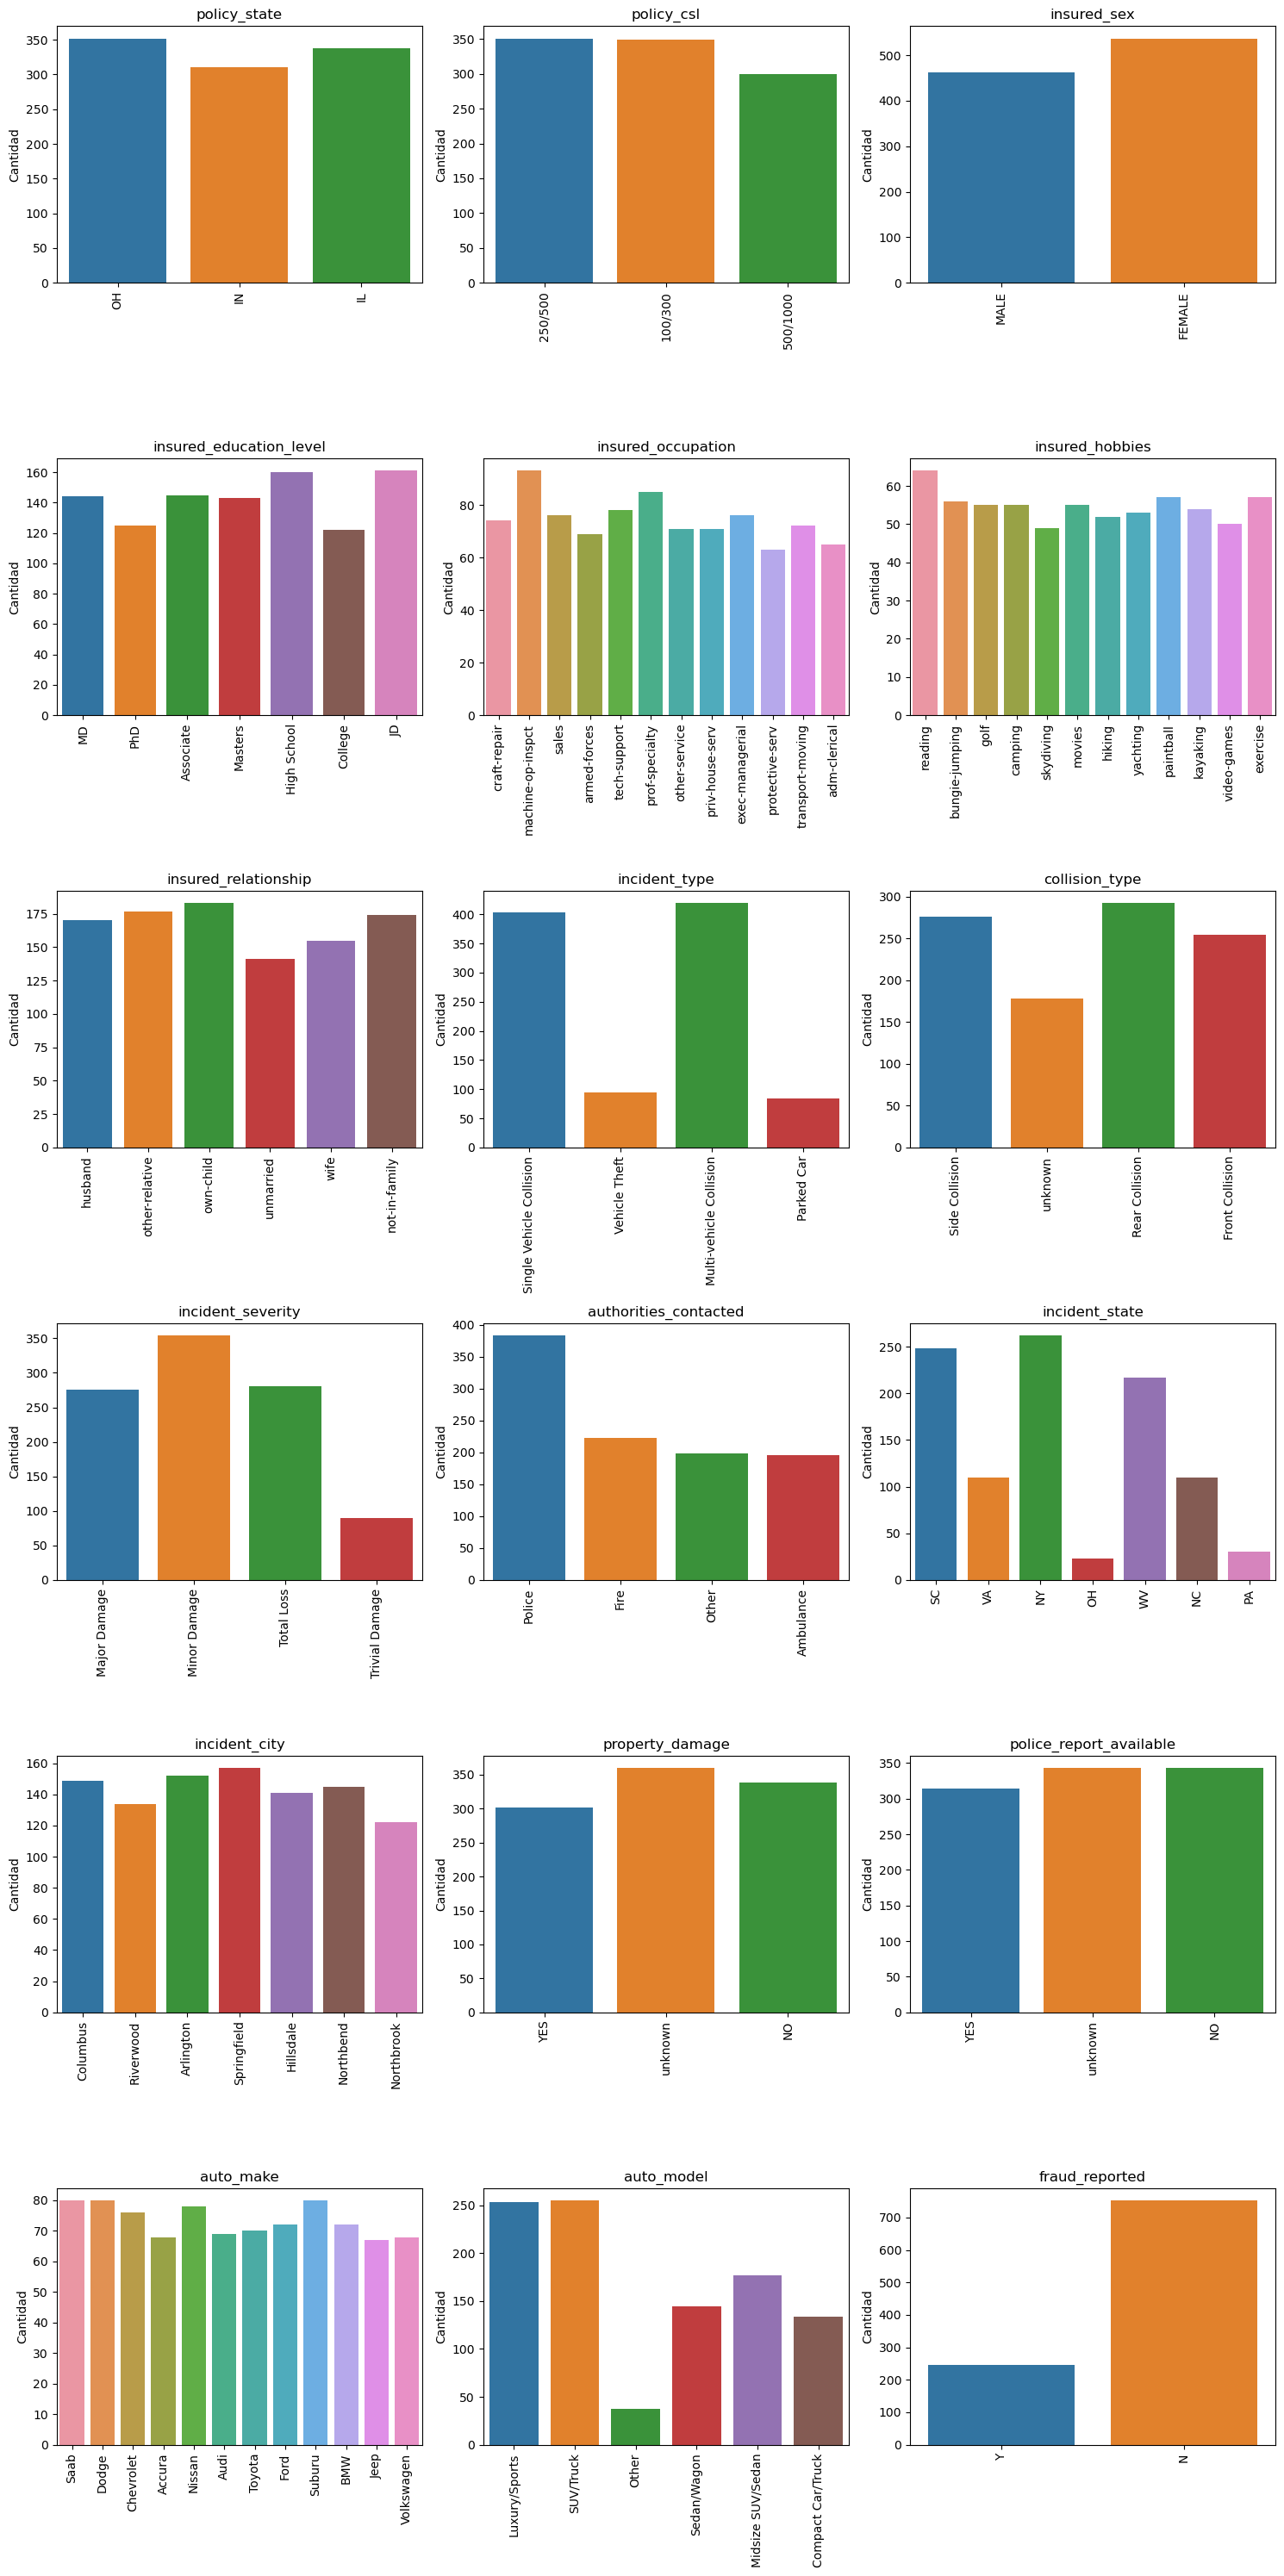

In [14]:
# obteniendo el nombre de las columnas categoricas
cat_vars = df.select_dtypes(include='object').columns.tolist()

# creando lienzo con subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando grafico de barras para cada variable categorica
for i, var in enumerate(cat_vars):
    top_values = df[var].value_counts().nlargest(12).index
    filtered_df = df[df[var].isin(top_values)]
    sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Cantidad')
    axs[i].tick_params(axis='x', rotation=90)

# removiendo subplots extras
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando espacios entre subplots
fig.tight_layout()

# mostrando grafico
plt.show()

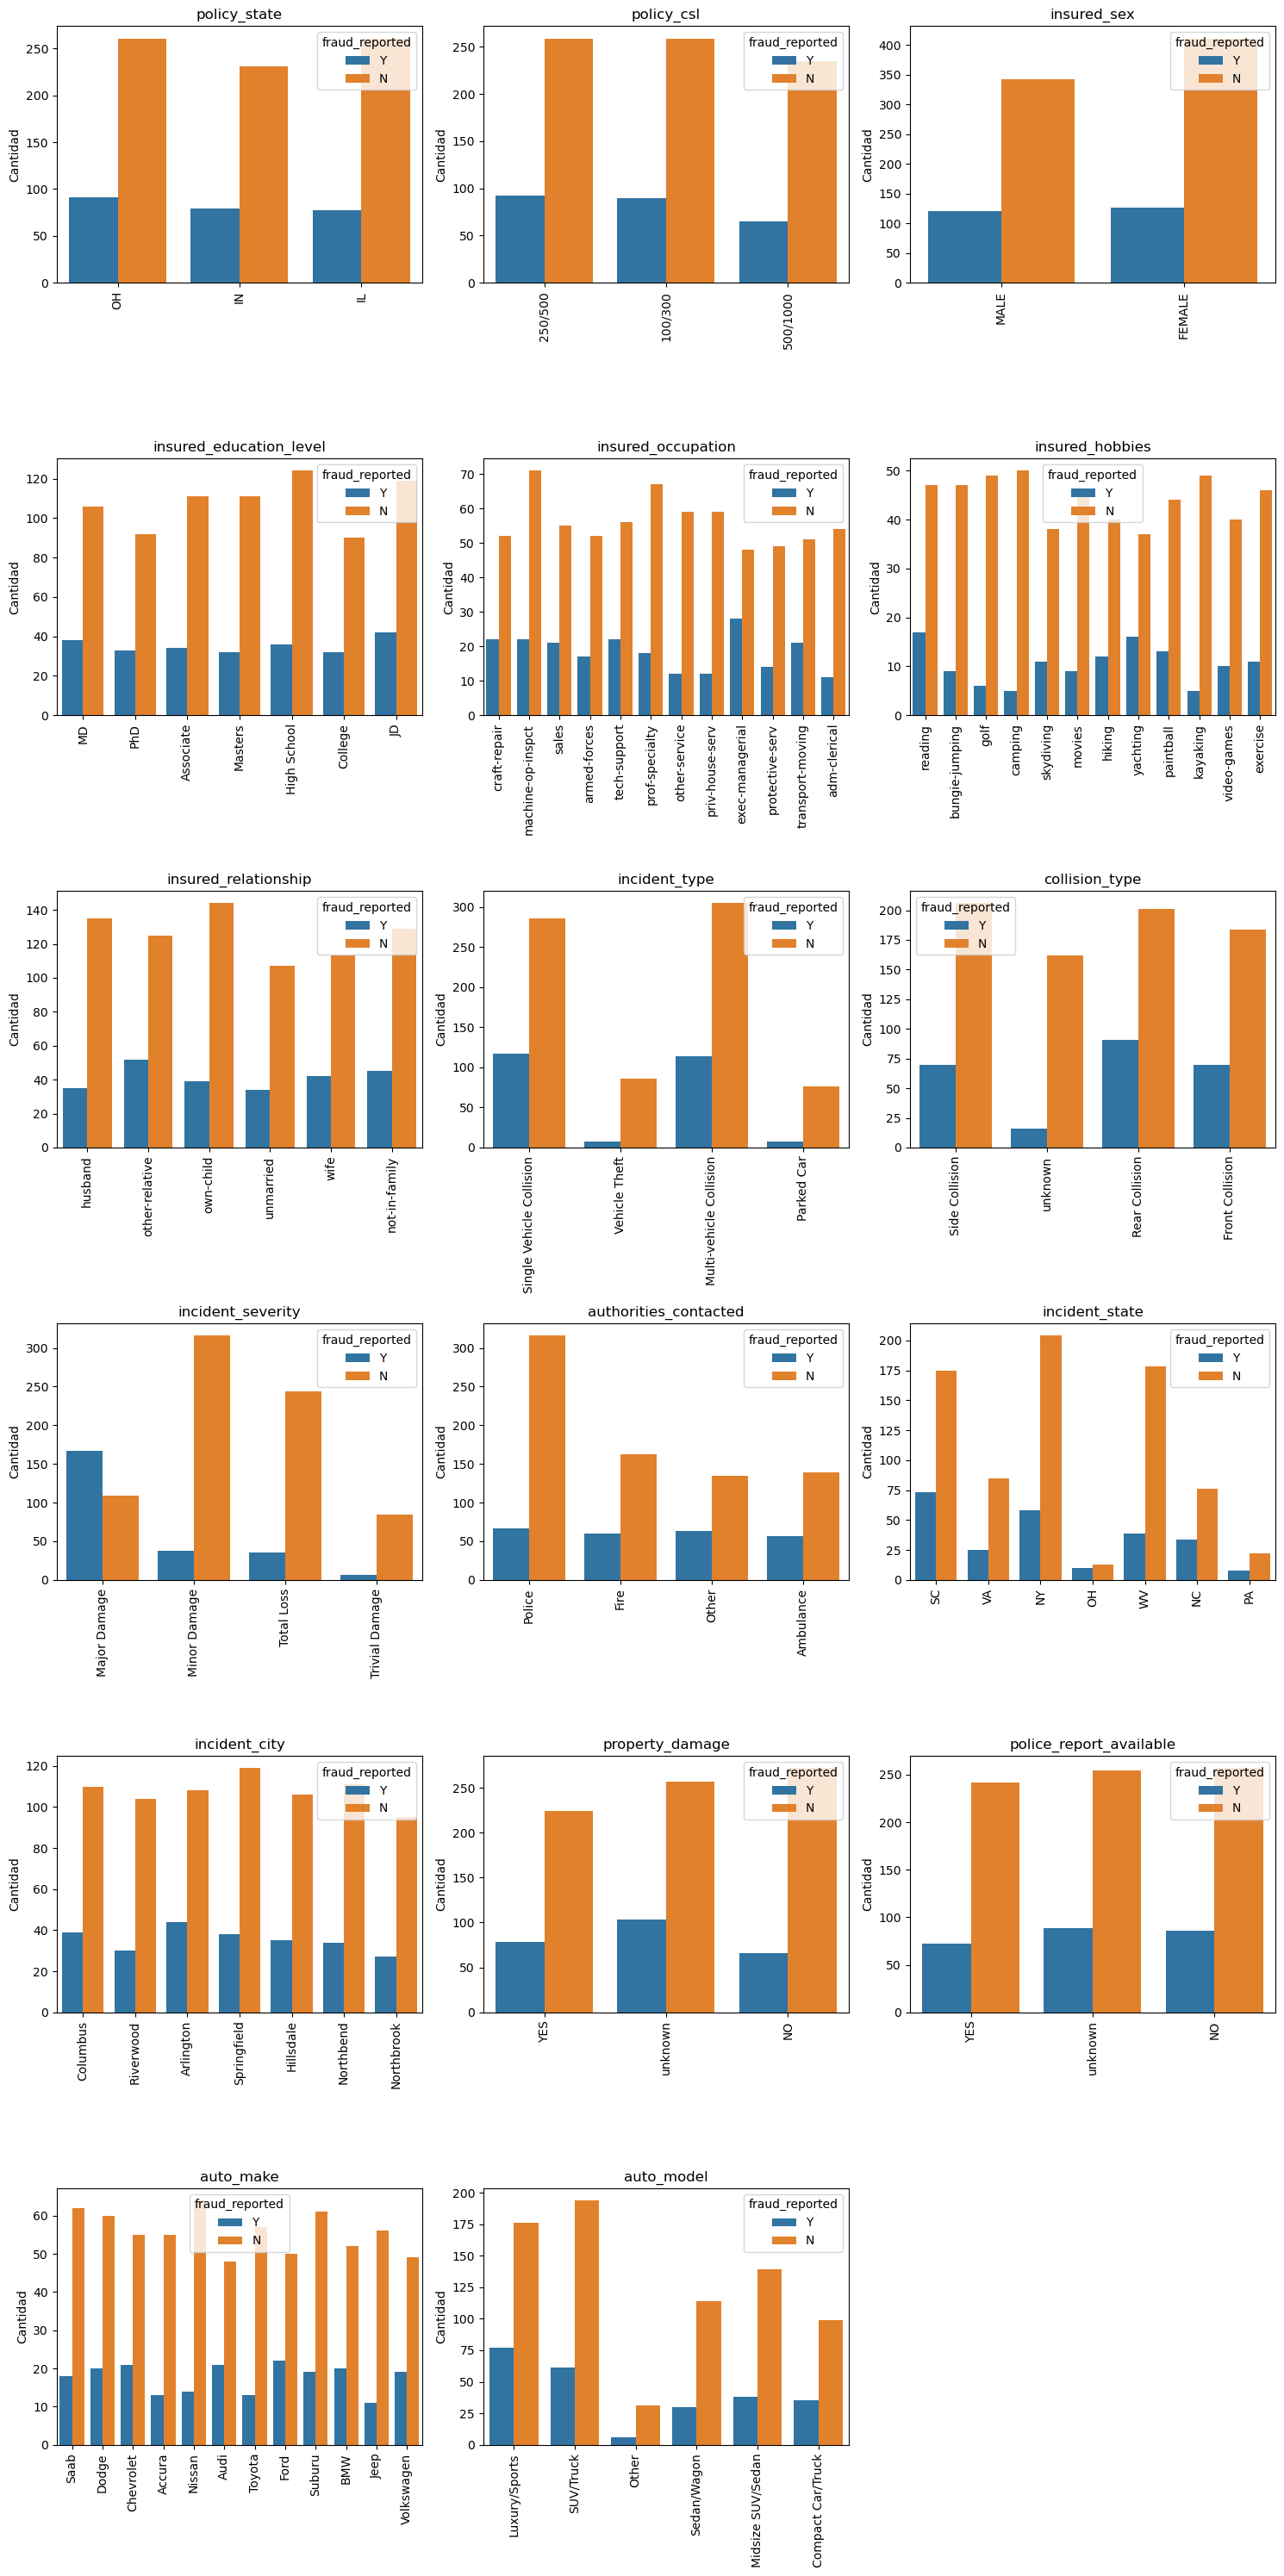

In [15]:
# obteniendo el nombre de las columnas categoricas
cat_vars = df.select_dtypes(include='object').columns.tolist()

# omitiendo la columna fraud_reported
cat_vars = [var for var in cat_vars if var != 'fraud_reported']

# creando lienzo con subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando grafico de barras para cada variable categorica
for i, var in enumerate(cat_vars):
    top_values = df[var].value_counts().nlargest(12).index
    filtered_df = df[df[var].isin(top_values)]
    sns.countplot(x=var, hue='fraud_reported', data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Cantidad')
    axs[i].tick_params(axis='x', rotation=90)

# removiendo subplots extras
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando espacios entre subplots
fig.tight_layout()

# mostrando grafico
plt.show()

## Análisis de variables númericas

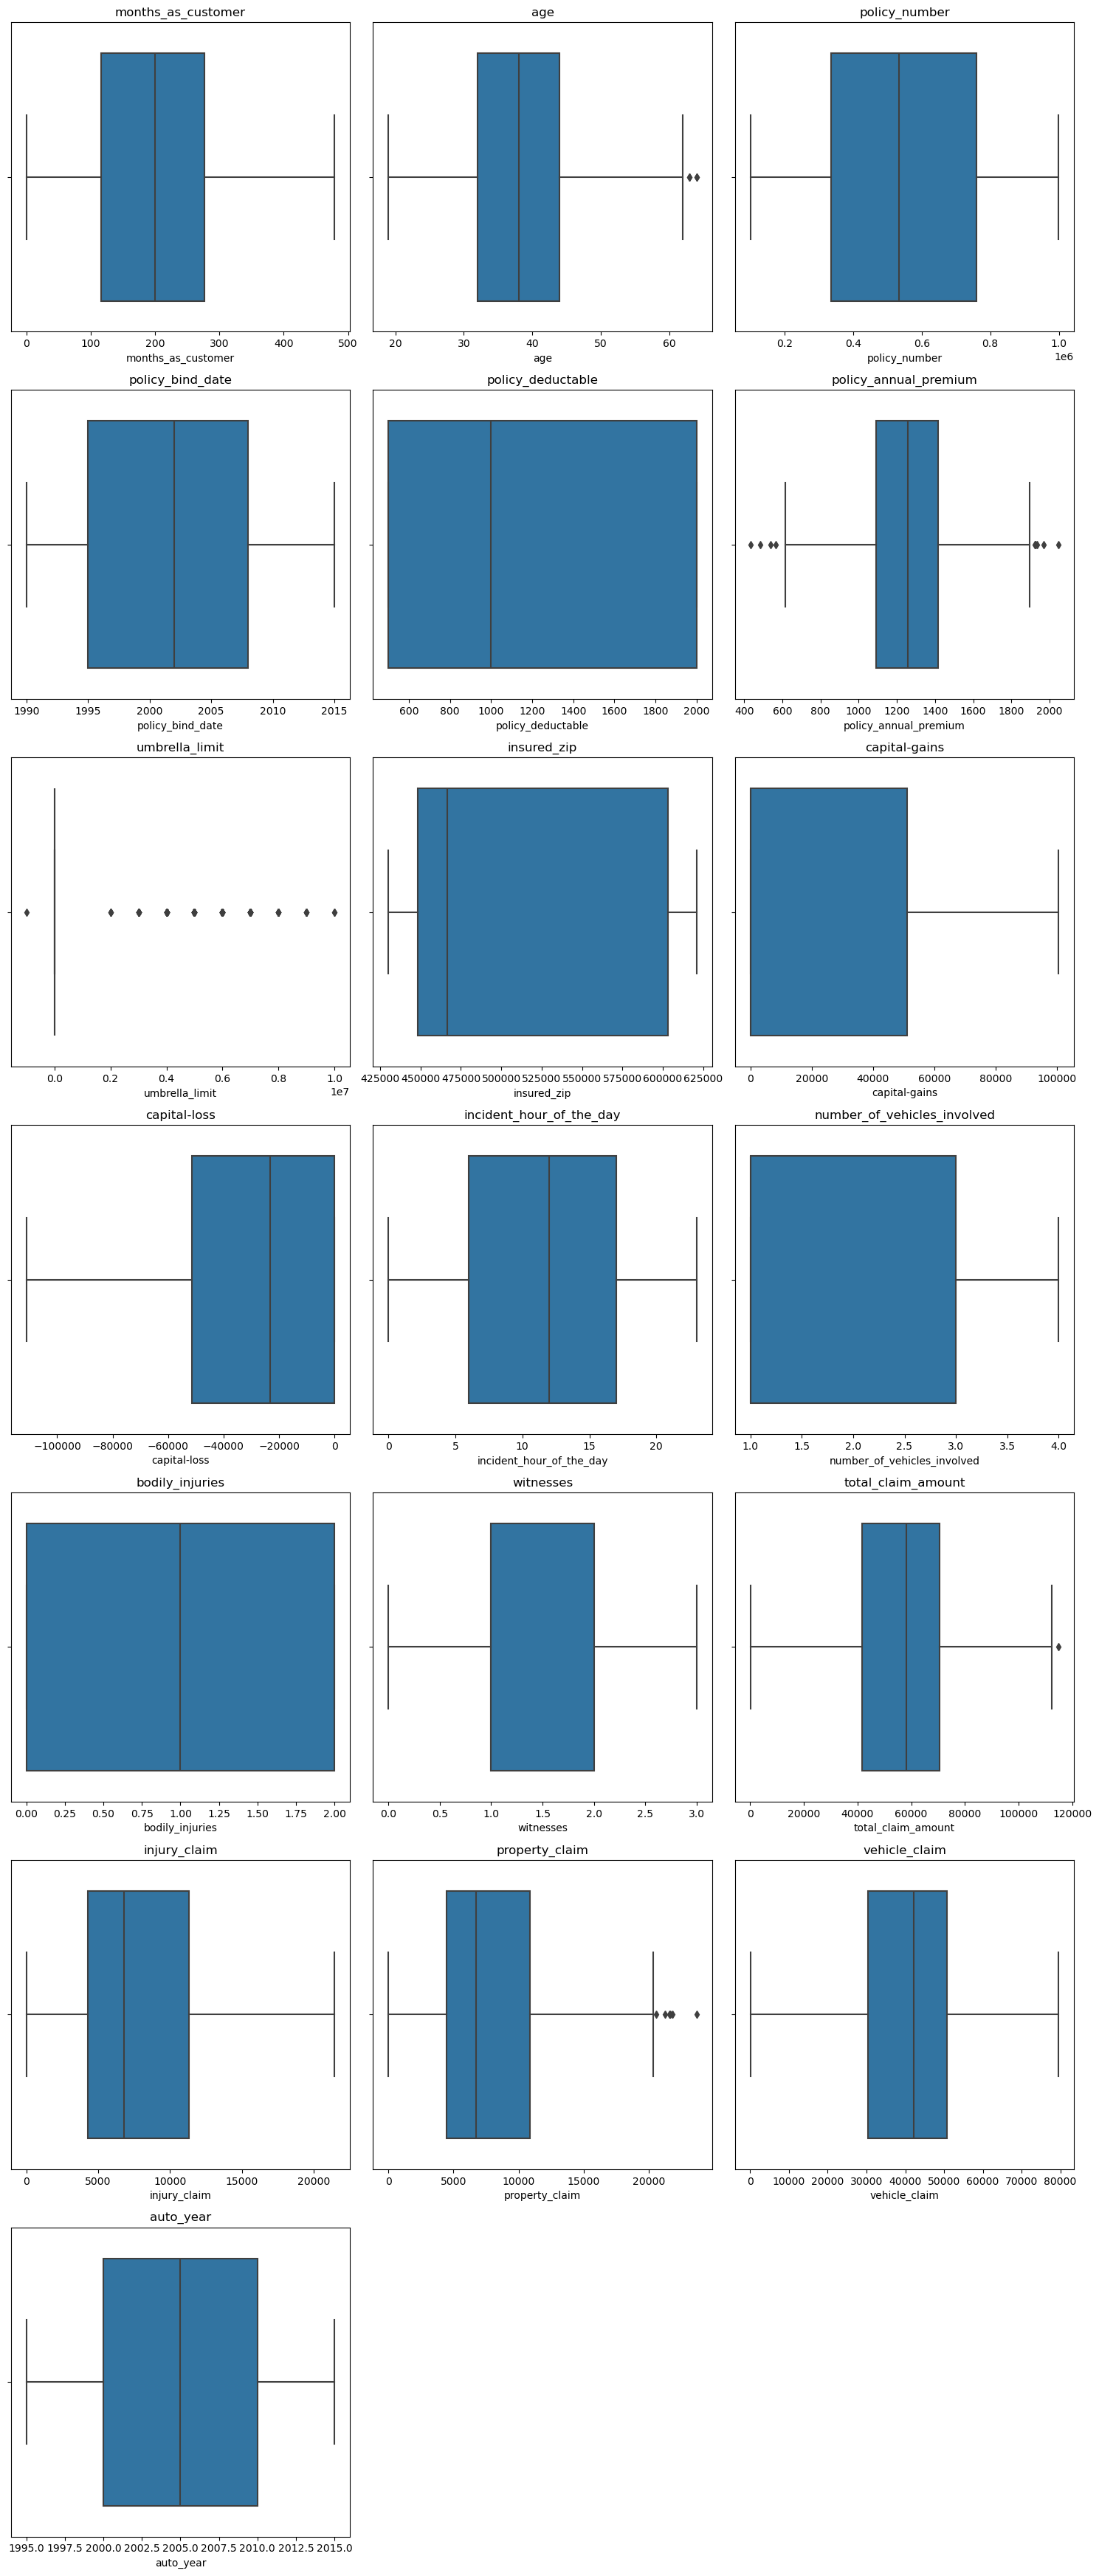

In [16]:
# obtiendo el nombre de las columnas numericas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()

# creando un lienzo con subplots
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un grafico de caja pro cada variable numerica
for i, var in enumerate(num_vars):
    sns.boxplot(x=df[var], ax=axs[i])
    axs[i].set_title(var)

# removiendo subplots extra
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando espacio entre subplots
fig.tight_layout()

# mostrando grafico
plt.show()

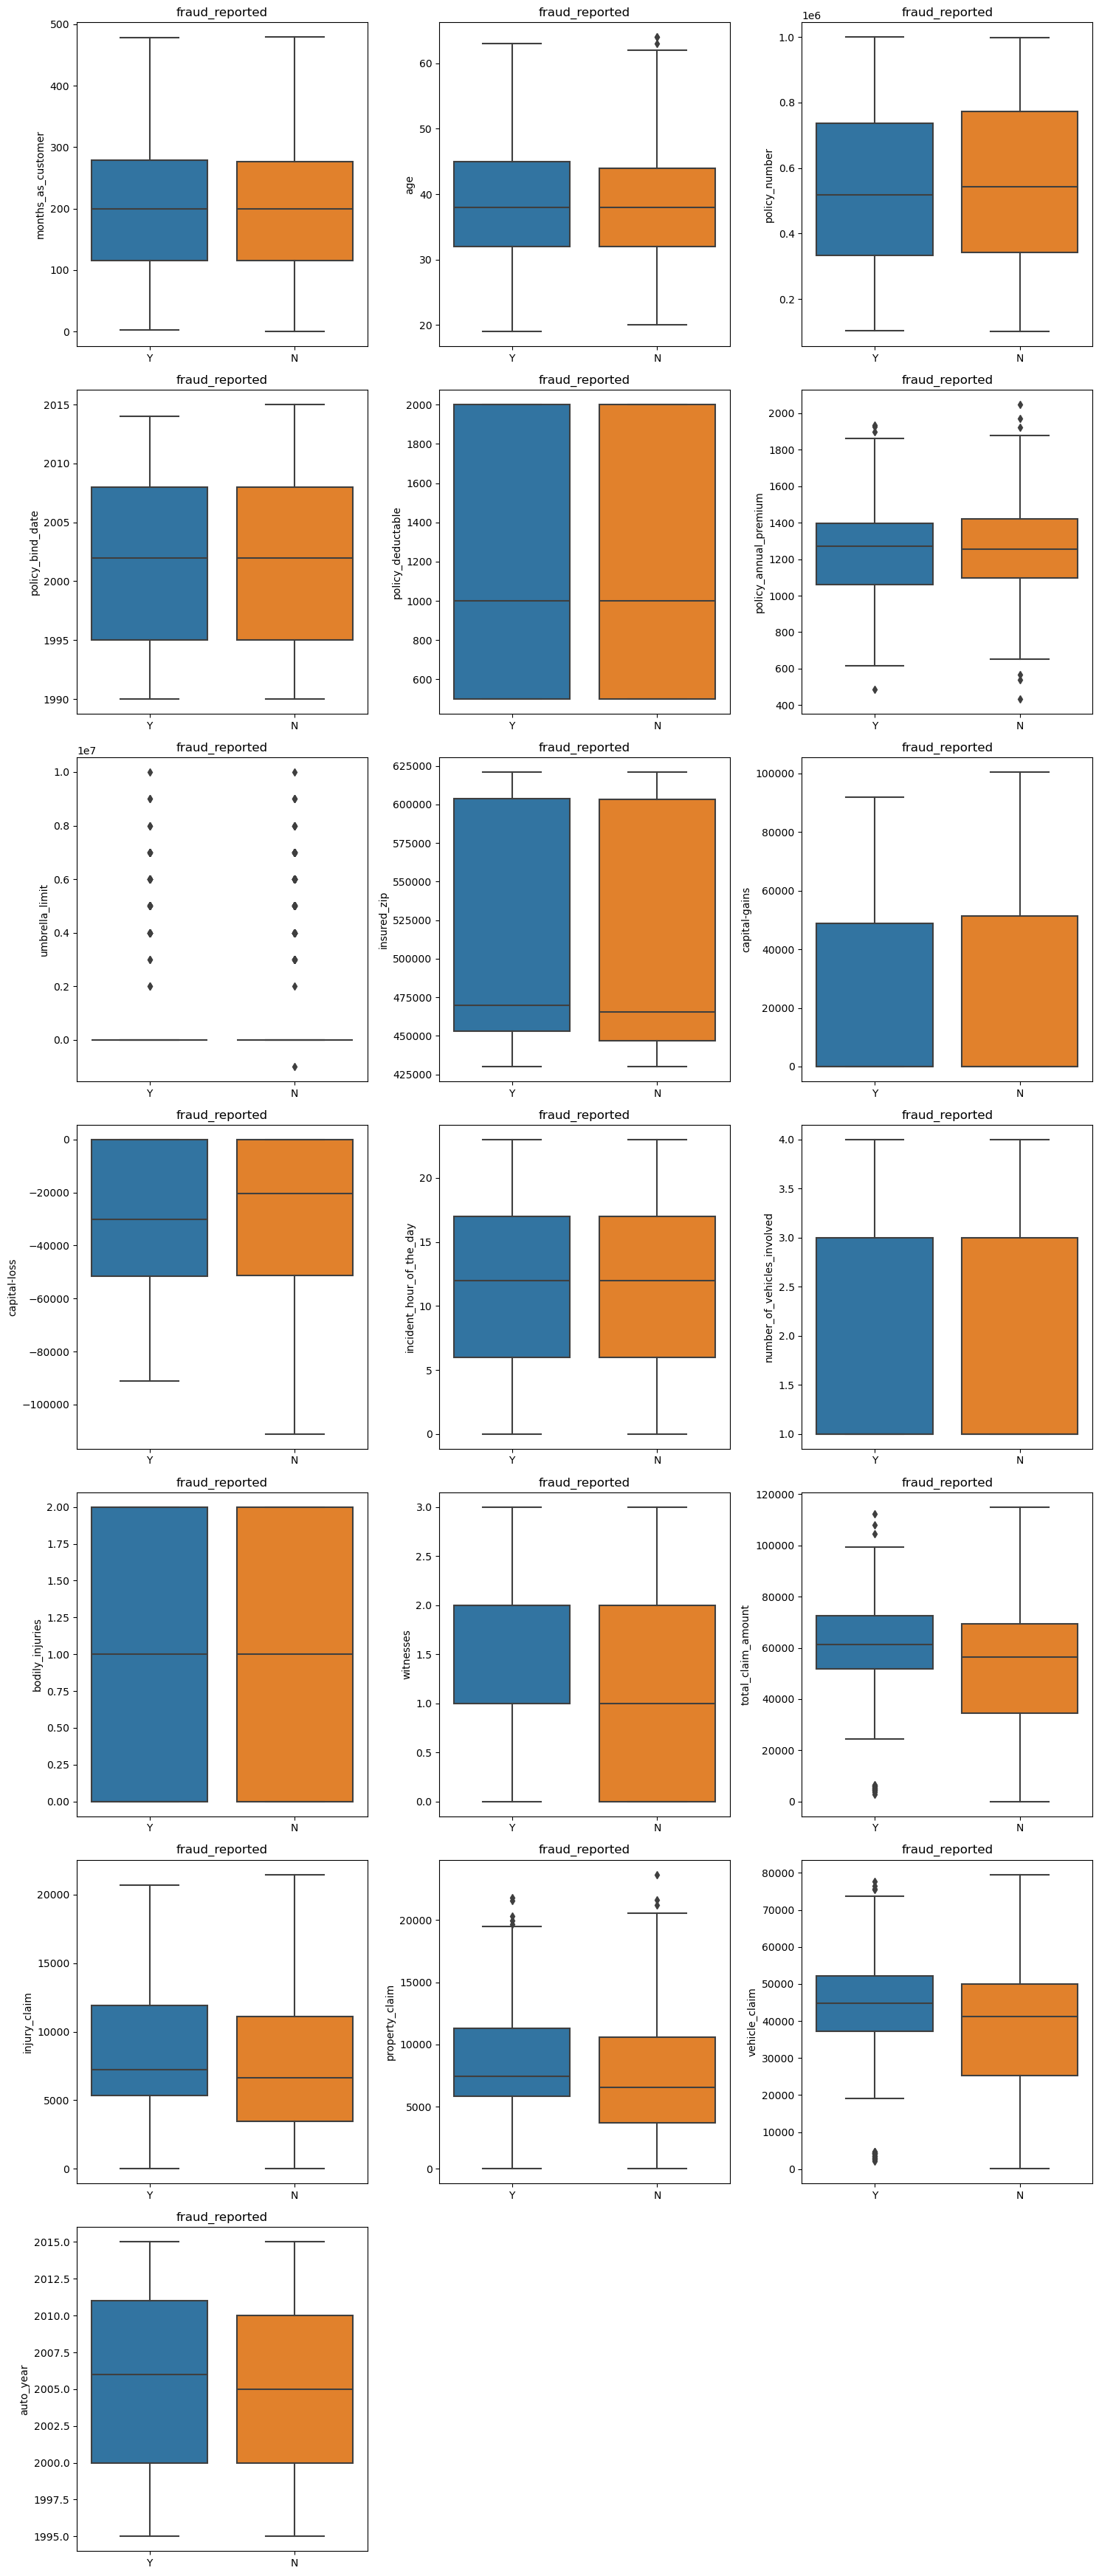

In [17]:
# obtiendo el nombre de las columnas numericas
int_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()

# creando un lienzo con subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un grafico de caja pro cada variable numerica
for i, var in enumerate(int_vars):
    sns.boxplot(y=var, x='fraud_reported', data=df, ax=axs[i])
    axs[i].set_title('fraud_reported')
    axs[i].set_xlabel('')

# removiendo subplots extra
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando espacio entre subplots
fig.tight_layout()

# mostrando grafico
plt.show()

# Label Encoding

In [18]:
# Loop por cada columna categorica
for col in df.select_dtypes(include=['object']).columns:
    
    # imprimiendo el nombre de la columna y sus clases
    print(f"{col}: {df[col].unique()}")

policy_state: ['OH' 'IN' 'IL']
policy_csl: ['250/500' '100/300' '500/1000']
insured_sex: ['MALE' 'FEMALE']
insured_education_level: ['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
insured_occupation: ['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
insured_hobbies: ['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']
insured_relationship: ['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
incident_type: ['Single Vehicle Collision' 'Vehicle Theft' 'Multi-vehicle Collision'
 'Parked Car']
collision_type: ['Side Collision' 'unknown' 'Rear Collision' 'Front Collision']
incident_severity: ['Maj

In [19]:
# Loop por cada columna categorica
for col in df.select_dtypes(include=['object']).columns:

    # creando un objecto LabelEncoder
    label_encoder = preprocessing.LabelEncoder()

    # entrenando el Encoder con los valores unicos de las columnas
    label_encoder.fit(df[col].unique())

    # transformando la columna usando el Encoder
    df[col] = label_encoder.transform(df[col])

    # imprimiendo el nombre de la columna y sus clases
    print(f"{col}: {df[col].unique()}")

policy_state: [2 1 0]
policy_csl: [1 0 2]
insured_sex: [1 0]
insured_education_level: [4 6 0 5 2 1 3]
insured_occupation: [ 2  6 11  1 12  9  7  8  3 10 13  5  0  4]
insured_hobbies: [17 15  2  3  0  9  4  7 16 12 10 19 13  5 11 14  1 18  6  8]
insured_relationship: [0 2 3 4 5 1]
incident_type: [2 3 0 1]
collision_type: [2 3 1 0]
incident_severity: [0 1 2 3]
authorities_contacted: [3 1 2 0]
incident_state: [4 5 1 2 6 0 3]
incident_city: [1 5 0 6 2 3 4]
property_damage: [1 2 0]
police_report_available: [1 2 0]
auto_make: [10  8  4  3  0  9  1 12  5 11  2  7  6 13]
auto_model: [1 4 3 5 2 0]
fraud_reported: [1 0]


# Mapa de calor

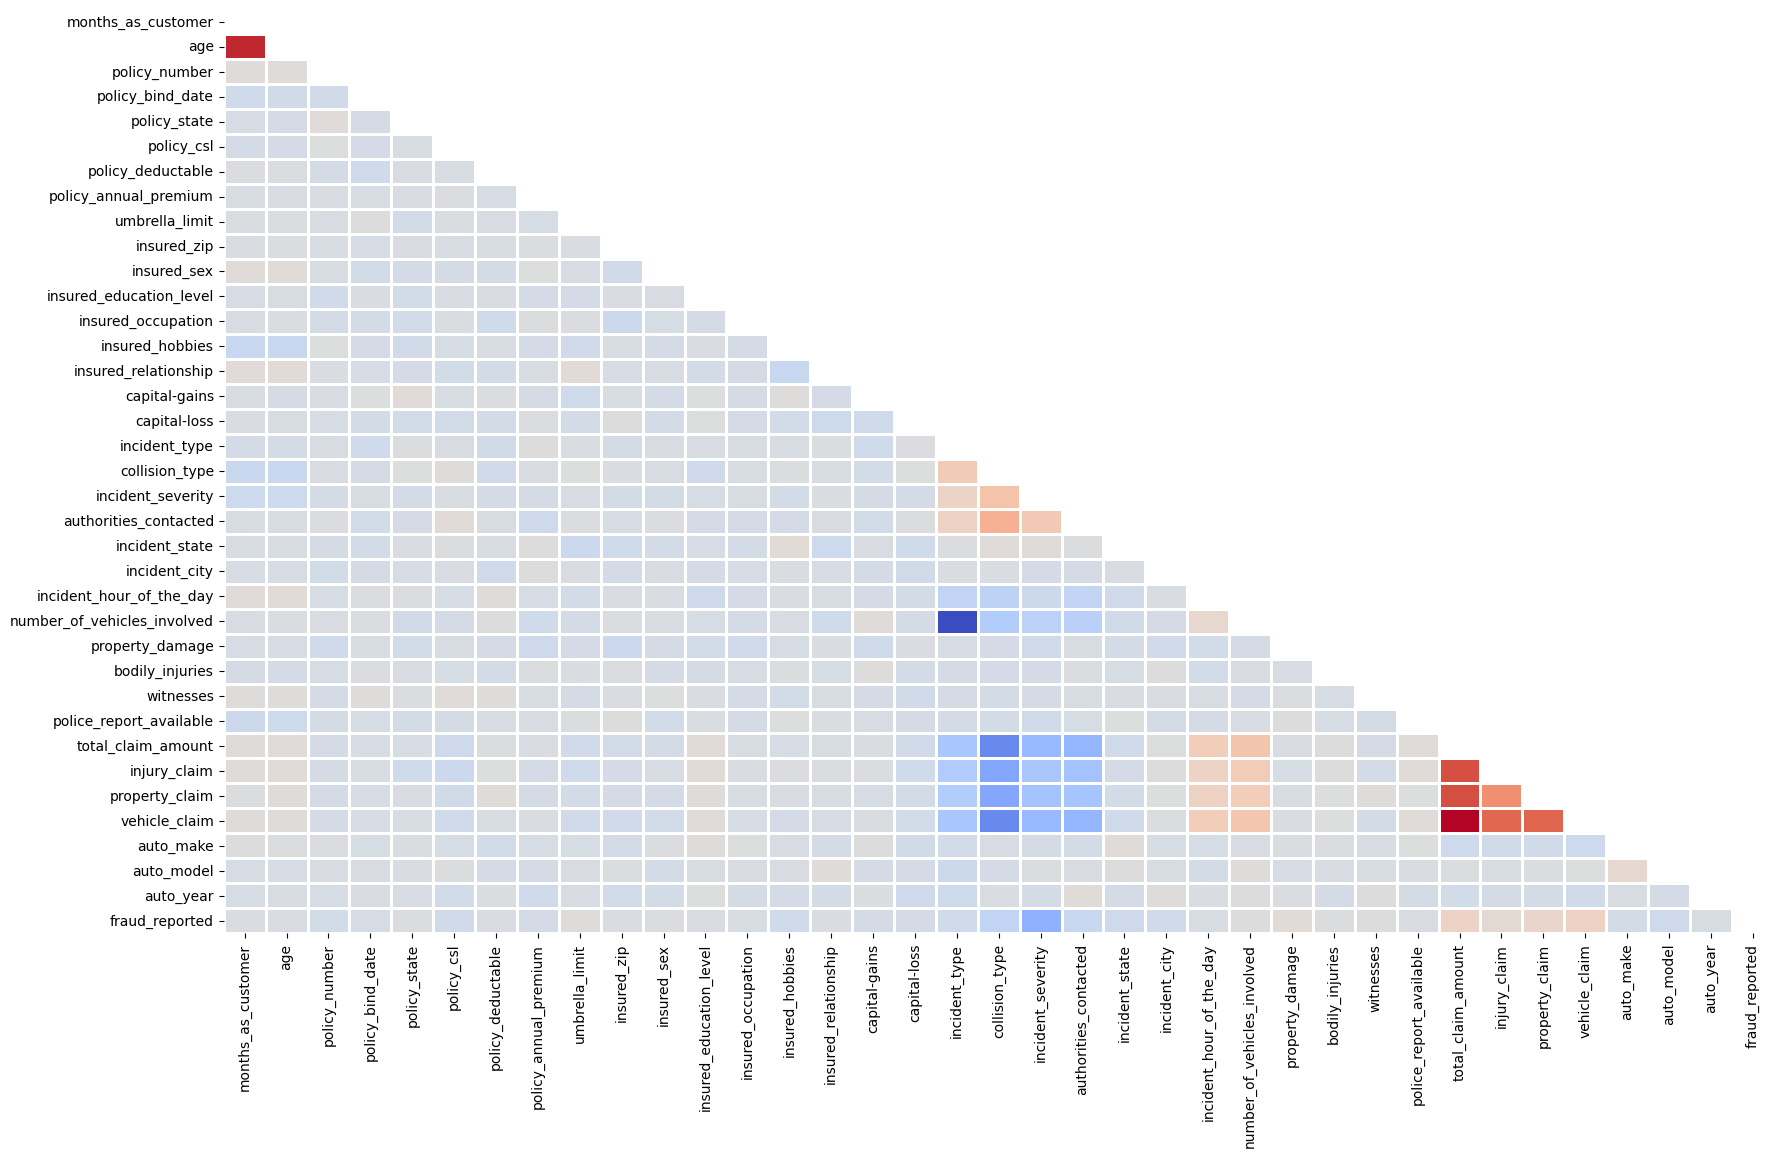

In [20]:
plt.figure(figsize=(20, 12)) # creando lienzo
matrix = np.triu(df.corr()) # creando matriz
sns.heatmap(df.corr(), annot=True,linewidth=.8, mask=matrix, cmap="coolwarm",cbar=False) # creando visual
plt.show()

In [21]:
# removiendo columnas que alta correlacion
df.drop(columns = ['vehicle_claim', 'months_as_customer', 'property_claim', 'injury_claim'], inplace=True)
df.head()

,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_make,auto_model,auto_year,fraud_reported
0,48,521585,2014,2,1,1000,1406.91,0,466132,1,4,2,17,0,53300,0,2,2,0,3,4,1,5,1,1,1,2,1,71610,10,1,2004,1
1,42,342868,2006,1,1,2000,1197.22,5000000,468176,1,4,6,15,2,0,0,3,3,1,3,5,5,8,1,2,0,0,2,5070,8,1,2007,1
2,29,687698,2000,2,0,2000,1413.14,5000000,430632,0,6,11,2,3,35100,0,0,1,1,3,1,1,7,3,0,2,3,0,34650,4,4,2007,0
3,41,227811,1990,0,1,2000,1415.74,6000000,608117,0,6,1,2,4,48900,-62400,2,0,0,3,2,0,5,1,2,1,2,0,63400,3,4,2014,1
4,44,367455,2014,0,2,1000,1583.91,6000000,610706,1,0,11,2,4,66000,-46000,3,3,1,3,1,0,20,1,0,0,1,0,6500,0,3,2009,0


# Normalizando las columnas con MinMaxScaler

In [22]:
# creando MinMaxScaler
scaler = MinMaxScaler()
# aplicando MinMaxScaler a todas las columnas numericas
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_make,auto_model,auto_year,fraud_reported
0,0.644444,0.468247,0.96,1.0,0.5,0.333333,0.603112,0.090909,0.188769,1.0,0.666667,0.153846,0.894737,0.0,0.530348,1.000000,0.666667,0.666667,0.000000,1.0,0.666667,0.166667,0.217391,0.000000,0.5,0.5,0.666667,0.5,0.622801,0.769231,0.2,0.45,1.0
1,0.511111,0.269370,0.64,0.5,0.5,1.000000,0.473214,0.545455,0.199478,1.0,0.666667,0.461538,0.789474,0.4,0.000000,1.000000,1.000000,1.000000,0.333333,1.0,0.833333,0.833333,0.347826,0.000000,1.0,0.0,0.000000,1.0,0.043285,0.615385,0.2,0.60,1.0
2,0.222222,0.653098,0.40,1.0,0.0,1.000000,0.606972,0.545455,0.002766,0.0,1.000000,0.846154,0.105263,0.6,0.349254,1.000000,0.000000,0.333333,0.333333,1.0,0.166667,0.166667,0.304348,0.666667,0.0,1.0,1.000000,0.0,0.300906,0.307692,0.8,0.60,0.0
3,0.488889,0.141334,0.00,0.0,0.5,1.000000,0.608582,0.636364,0.932699,0.0,1.000000,0.076923,0.105263,0.8,0.486567,0.438344,0.666667,0.000000,0.000000,1.0,0.333333,0.000000,0.217391,0.000000,1.0,0.5,0.666667,0.0,0.551298,0.230769,0.8,0.95,1.0
4,0.555556,0.296730,0.96,0.0,1.0,0.333333,0.712760,0.636364,0.946264,1.0,0.000000,0.846154,0.105263,0.8,0.656716,0.585959,1.000000,1.000000,0.333333,1.0,0.166667,0.000000,0.869565,0.000000,0.0,0.0,0.333333,0.0,0.055739,0.000000,0.6,0.70,0.0


# Train Test Split

In [23]:
X = df.drop('fraud_reported', axis=1) # variables independientes
y = df['fraud_reported'] # variable dependiente

# definiendo datos de prueba y datos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

# Red Neuronal

In [24]:
# calculando peso de las clases
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(class_labels, class_weights))

In [25]:
# configuracion de la red neuronal usando un modelo secuencial
model = Sequential([
    Dense(128, activation='tanh', input_shape=(X_train.shape[1],)), # capa densa de 128 neuronas con funcion de activacion tanh
    Dense(64, activation='tanh'), # capa densa de 64 neuronas con funcion de activacion tanh
    Dense(32, activation='tanh'), # capa densa de 32 neuronas con funcion de activacion tanh
    Dense(1, activation='sigmoid') # capa densa de 1 neurona con funcion de activacion sigmoid
])

In [26]:
# compilando la red neuronal usando el optimizador adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # entropía cruzada binaria
              metrics=['accuracy']) # métrica de accuracy

In [27]:
# entrenando la red neuronal usando batch size y epochs, además del class weights
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5369 - loss: 0.6860 - val_accuracy: 0.4062 - val_loss: 0.7299
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5775 - loss: 0.6469 - val_accuracy: 0.6375 - val_loss: 0.6305
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6761 - loss: 0.6051 - val_accuracy: 0.6125 - val_loss: 0.6252
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7164 - loss: 0.5883 - val_accuracy: 0.6187 - val_loss: 0.6220
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.5670 - val_accuracy: 0.6625 - val_loss: 0.5901
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.5514 - val_accuracy: 0.6625 - val_loss: 0.6001
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7530 - loss: 0.5435 - val_accuracy: 0.6562 - val_loss: 0.5995
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7583 - loss: 0.5347 - val_accuracy: 0.6875 - val_loss

# Evaluación del modelo

In [28]:
# evaluación de la red neuronal
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.7549 - loss: 0.5786
Test accuracy: 0.7549999952316284


In [29]:
# Accuracy
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) 
accuracy = accuracy_score(y_test, y_pred)*100 # convirtiendo el valor a porcentaje
print("Accuracy:", accuracy, " %") # imprimiendo metrica

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 75.5  %


In [33]:
# calculando la precision, recall y el F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# convirtiendo valores a porcentajes
precision_percent = precision * 100
recall_percent = recall * 100
f1_score_percent = f1_score * 100

# imprimiendo metricas
print("Precision:", precision_percent, "%")
print("Recall:", recall_percent, "%")
print("F1-score:", f1_score_percent, "%")

Precision: 55.4054054054054 %
Recall: 71.9298245614035 %
F1-score: 62.59541984732825 %


In [35]:
# prediciendo la probabilidad para la clase positiva (clase 1)
y_pred_prob = model.predict(X_test)

# extrayendo la probabilidad de la clase positiva
y_pred_prob_positive = y_pred_prob[:, 0]

# calculando el ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob_positive)
print("ROC-AUC:", roc_auc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
ROC-AUC: 0.7716844558949822
